### They are all equally spaced

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [2]:
########################################                 Define constants                   #############################################
phi = np.pi/2 #np.arctan(dy/dx)
N      = 3

x_0    = 0.002
x_max  = 2
x_size = 150
t_max  = 40
t_size = 100

########################################################################################################################    
gamma = 1
t_vals = np.linspace(0, t_max, t_size) * gamma
x_vals = np.linspace(x_0, x_max, x_size) # Create the distances x = r/lambda0 from x_0 to x_max 

[[ 2.88675135e-01  5.00000000e-01]
 [-5.77350269e-01  7.07050159e-17]
 [ 2.88675135e-01 -5.00000000e-01]]


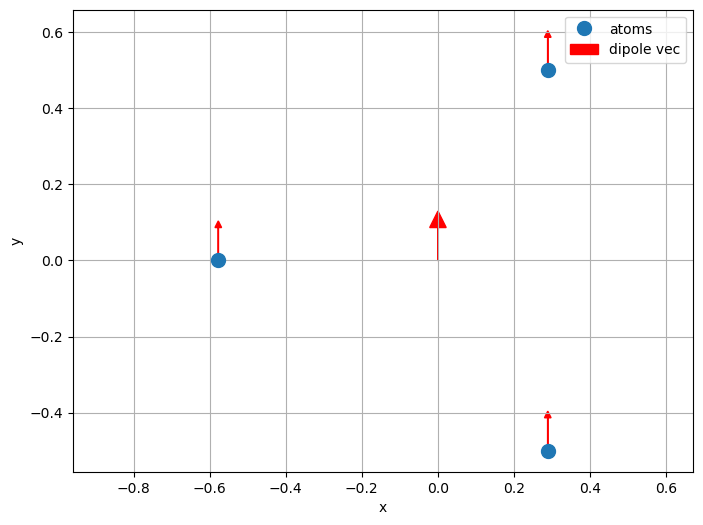

In [3]:
########################################               define the geometry                 #############################################
def dipole_vector(phi):
    """Returns the dipole vector given its magnitude and direction angle phi."""
    phi = np.array([np.cos(phi), np.sin(phi)])
    return (phi / np.linalg.norm(phi))
d_hat = dipole_vector(phi)

def atom_positions(N: int, distance: float = 1):
    """Returns the positions of the N atoms in a 2D shape."""
    # Start with an initial guess for x
    x = distance / (2 * np.sin(np.pi / N))

    # Define a function to calculate the distance between adjacent atoms
    def calculate_distances(x):
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
        adjusted_angles = angles + np.pi / N
        x_coords = np.cos(adjusted_angles) * x
        y_coords = np.sin(adjusted_angles) * x
        pos = np.column_stack((x_coords, y_coords))
        distances = np.linalg.norm(np.diff(np.vstack((pos, pos[0])), axis=0), axis=1)
        return distances

    # Use an iterative approach to adjust x until the desired distance condition is met
    def optimize_x(x):
        distances = calculate_distances(x)
        return np.abs(np.mean(distances) - distance)

    # Use scipy.optimize to find the optimal value of x
    from scipy.optimize import minimize
    result = minimize(optimize_x, x, method='Nelder-Mead')

    if result.success:
        x = result.x[0]
    else:
        raise ValueError("Optimization failed.")

    # Calculate the final positions using the optimized x
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    adjusted_angles = angles + np.pi / N
    x_coords = np.cos(adjusted_angles) * x
    y_coords = np.sin(adjusted_angles) * x
    pos = np.column_stack((x_coords, y_coords))

    return pos

positions = atom_positions(N)
print(positions)
# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.3 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
# Plot dipole vectors
for i, position in enumerate(positions):
    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [4]:
########################################             create the Hamiltonean                 #################################################
def ladder_operator(i, N, operator_type):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()


def effective_hamiltonian(d_hat: np.array,gamma: float, distance: float, N: int):
    pos = atom_positions(N, distance)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, N, 'raising')
            lowering_op_j = ladder_operator(j+1, N, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma


def reduced_H(H_list: list):
    H_reduced_list = []
    # Generate the single excitation basis: N elems with dimension 2**N
    single_exc_basis = single_excitation_basis(N)

    # Reduce the Hamiltonians to the single excitation subspace
    for H in H_list:
        H_reduced = np.zeros((N, N), dtype=complex)
        for i, bra in enumerate(single_exc_basis):
            for j, ket in enumerate(single_exc_basis):
                H_reduced[i, j] = H.matrix_element(bra.dag(), ket)
        H_reduced_list.append(Qobj(H_reduced))

    return [Qobj(H) for H in H_reduced_list]

In [5]:
# example form of the Hamiltonean
H_ex = effective_hamiltonian(d_hat, 1, 1, N)
H_red_ex = reduced_H([H_ex])
H_ex

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dia, isherm=False
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        -0.5j        -0.08876876-0.00474943j
   0.        +0.j         -0.00604716+0.03799544j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.08876876-0.00474943j  0.        -0.5j
   0.        +0.j         -0.08876876-0.00474943j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        -1.j          0.        +0.j         -0.08876876-0.00474943j
  -0.00604716+0.03799544j  0.        +0.j        ]
 [ 0.        +0.j         -0.00604716+0.03799544j -0.08876876-0.00474943j
   0.        +0.j          0.        -0.5j         0.        +0.j
   

In [6]:
def calculate_norms(x_vals, t_vals, H_list, Psi_0):
    all_norms = []
    for i, x in enumerate(x_vals):
        H = H_list[i]
        norms = []

        progress_bar = tqdm(t_vals, desc=f"Calculating norms for x={x:.2f}", unit="timestep", leave=False)
        for t in progress_bar:
            U = (-1j * H * t).expm()
            Psi_t = U * Psi_0
            norm_sq = Psi_t.norm()**2
            norms.append(norm_sq)

        all_norms.append(norms)
    return all_norms

In [7]:
H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in x_vals]

In [117]:
#############################################---------        N x N case           ---------###########################################################

In [118]:
H_red_list = reduced_H(H_list)
print('NxN H_eff:', H_red_list[0])

#Psi_01 = generic_superposition([basis(N, i) for i in range(N-1)])
Psi_01 = (basis(N,0)-basis(N,1)).unit() # only one atom is excited
print('Psi(0):', Psi_01)
norms = calculate_norms(x_vals, t_vals, H_red_list, Psi_01)

In [119]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is N x N; for symmetric distance values')
#plt.legend()
plt.show()

In [120]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is N x N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_.mp4', writer='ffmpeg')
plt.show()

In [22]:
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_230
# plot phi(distances)
H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in x_vals]
H_red_list = reduced_H(H_list)

# Calculate the phases for the off-diagonal elements
phases_12 = [np.angle(H[0, 1]) / np.pi for H in H_red_list]
phases_13 = [np.angle(H[0, 2]) / np.pi for H in H_red_list]
phases_23 = [np.angle(H[1, 2]) / np.pi for H in H_red_list]

# Plotting the phases   
plt.figure(figsize=(15, 5))
plt.plot(x_vals, phases_12, label=r'$H_{12}$')
plt.plot(x_vals, phases_13, label=r'$H_{31}$') #its the same as 12

plt.xlabel(r'Distance x / $\lambda_0$')
plt.ylabel(r'Phase / $\pi$')
plt.title('Phase of off-diagonal entries of H over distances')
plt.legend()
plt.savefig('phase_plot.png', dpi=300)  
plt.show()

## It does matter whether or not I reduce the Hamiltonean!!

In [78]:
#############################################---------      2^N x 2^N case         ----------##################################################

In [79]:
#### x = lambda / 2 case:
x_special = 0.5
x_vals_ = np.concatenate((x_vals[[0, int(x_size/2), -1]], np.array([x_special])))

print(f'2^{N} x 2^{N} H_eff: ', H_list[0])

single_exc_basis = single_excitation_basis(N)
#Psi_0 = generic_superposition(single_exc_basis)
Psi_0 = (single_exc_basis[N-1] + single_exc_basis[N-2]).unit()  # only the first atom is excited
print('Psi(0):', Psi_0)

norms = calculate_norms(x_vals, t_vals, H_list, Psi_0)

In [80]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is2^N x 2^N; for symmetric distance values')
#plt.legend()
plt.show()

In [81]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is 2^N x 2^N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_sq.mp4', writer='ffmpeg')
plt.show()